# Figure 4f

In [2]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from cnmf import cNMF

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

seed = 777

output_path = '../output/forNMF/scVI_filter'
data_path = '../output/'
plot_path = '../plot/'
marker_path = '../markers/'

In [3]:
adata = sc.read_h5ad(os.path.join(output_path, 'subcluster.h5ad'))
cnmf_obj = cNMF(output_dir = '../output/forNMF/scVI_filter', name = 'subcluster')
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=8, density_threshold=0.5)
usage_norm.columns = [f'NMF_Module_{i}' for i in usage_norm.columns]

adata.obs = pd.merge(left = adata.obs, right = usage_norm, left_index = True, right_index = True, how = 'left')

adata.obs['max_module'] = usage_norm.idxmax(1)

pt = pd.read_csv(os.path.join(marker_path, 'pseudotime.csv'), index_col = 0, names=['pseudotime'], skiprows=1)
adata.obs = pd.merge(left = adata.obs, right = pt, left_index = True, right_index = True, how = 'left')
adata

AnnData object with n_obs × n_vars = 16088 × 10350
    obs: 'sample_id', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'grade', 'GFP', '_scvi_batch', '_scvi_labels', 'leiden_res2', 'old_cell_type', 'wb_anno', 'wb_conf_score', 'gb_anno', 'gb_conf_score', 'cellid_prediction', 'cell_type', 'leiden', 'NMF_Module_1', 'NMF_Module_2', 'NMF_Module_3', 'NMF_Module_4', 'NMF_Module_5', 'NMF_Module_6', 'NMF_Module_7', 'NMF_Module_8', 'max_module', 'pseudotime'
    var: 'n_cells'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden', 'leiden_res2_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [4]:
adata.write(os.path.join(output_path, 'subcluster_pt.h5ad'))

- Psuedobulk DEG

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

import random
from pathlib import Path
import os
import warnings

from scipy.stats import gaussian_kde
import decoupler
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import gseapy as gp
from gseapy.plot import gseaplot
from gseapy import Biomart

from sanbomics.tools import id_map
from sanbomics.plots import volcano
warnings.filterwarnings('ignore')

seed = 777

output_path = '../output/forNMF/scVI_filter'
data_path = '../output/'
plot_path = '../plot/'
marker_path = '../markers/'

In [77]:
def do_pseudobulk(adata, condition, reference, seed = 123):
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) 
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0).reshape(1,-1),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        ref_level=['condition' ,reference],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [106]:
def gmt_to_decoupler(path):
    from itertools import chain, repeat
    pathways = {}
    
    with Path(path).open('r') as f:
        for line in f:
            name, _, *genes = line.strip().split('\t')
            pathways[name] = genes
    
    return pd.DataFrame.from_records(chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()), columns=['geneset', 'genesymbol'])

m2_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/m2.all.v2023.2.Mm.symbols.gmt'
mh_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/mh.all.v2023.2.Mm.symbols.gmt'

In [99]:
adata = sc.read_h5ad(os.path.join(output_path, 'subcluster_pt.h5ad'))
adata

AnnData object with n_obs × n_vars = 16088 × 10350
    obs: 'sample_id', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'grade', 'GFP', '_scvi_batch', '_scvi_labels', 'leiden_res2', 'old_cell_type', 'wb_anno', 'wb_conf_score', 'gb_anno', 'gb_conf_score', 'cellid_prediction', 'cell_type', 'leiden', 'NMF_Module_1', 'NMF_Module_2', 'NMF_Module_3', 'NMF_Module_4', 'NMF_Module_5', 'NMF_Module_6', 'NMF_Module_7', 'NMF_Module_8', 'max_module', 'pseudotime'
    var: 'n_cells'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden', 'leiden_res2_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [100]:
adata = adata[~(adata.obs.cell_type == "COP")].copy()
adata.X = adata.layers['counts'].copy()
adata

AnnData object with n_obs × n_vars = 15889 × 10350
    obs: 'sample_id', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'grade', 'GFP', '_scvi_batch', '_scvi_labels', 'leiden_res2', 'old_cell_type', 'wb_anno', 'wb_conf_score', 'gb_anno', 'gb_conf_score', 'cellid_prediction', 'cell_type', 'leiden', 'NMF_Module_1', 'NMF_Module_2', 'NMF_Module_3', 'NMF_Module_4', 'NMF_Module_5', 'NMF_Module_6', 'NMF_Module_7', 'NMF_Module_8', 'max_module', 'pseudotime'
    var: 'n_cells'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden', 'leiden_res2_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [101]:
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()

In [102]:
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.46 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.45 seconds.

Fitting LFCs...
... done in 0.24 seconds.

Replacing 16 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                        baseMean  log2FoldChange     lfcSE      stat  \
Xkr4                 1360.551270       -1.123630  0.324216 -3.465680   
Gm19938                77.931403       -0.881185  0.563556 -1.563616   
Mrpl15                299.727338        0.559670  0.324258  1.726005   
Lypla1                154.339186       -0.143806  0.325041 -0.442423   
Tcea1                 615.711042       -0.255266  0.193853 -1.316801   
...                          ...             ...       ...       ...   
mt-Nd5                710.073994        0.465090  0.231977  2.004898   
mt-Nd6                123.532380        1.281898  0.640849  2.000311   
mt-Cytb             13032.060294        0.728304  0.133517  5.454773   
ENSMUSG00000095041   1126.996546        1.549962  0.268154  5.780128   
Cas9-EGFP             468.735606        1.394060  0.629743  2.213697   

                          pvalue      padj  
Xkr4                5.288928e

... done in 0.32 seconds.



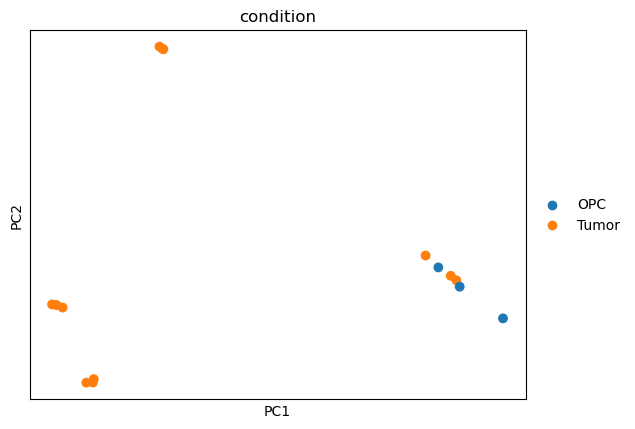

In [103]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

In [104]:
mapper = id_map(species='mouse')
def map_ids(gene):
    if gene in mapper.mapper.keys():
        return mapper.mapper[gene]
    else:
        return gene
de["Symbol"] = de.index.map(map_ids)

de = de[de.baseMean >= 10]
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 1)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Xkr4,1360.551270,-1.123630,0.324216,-3.465680,5.288928e-04,0.020114,Xkr4
Snhg6,362.676058,1.705532,0.524497,3.251746,1.146983e-03,0.029854,Snhg6
Rpl7,4583.051219,1.060520,0.309678,3.424585,6.157383e-04,0.021859,Rpl7
Gpr45,249.645432,-1.132026,0.238726,-4.741949,2.116716e-06,0.000676,Gpr45
Stat1,319.792237,1.410277,0.423630,3.329030,8.714915e-04,0.025867,Stat1
...,...,...,...,...,...,...,...
Msn,310.263939,1.660226,0.499334,3.324882,8.845583e-04,0.025867,Msn
Rps4x,5151.446239,1.044611,0.270621,3.860057,1.133607e-04,0.008905,Rps4x
Nxt2,109.468562,-1.164352,0.381255,-3.053994,2.258169e-03,0.044056,Nxt2
Zrsr2,239.860989,2.143891,0.550725,3.892853,9.907203e-05,0.008844,Zrsr2


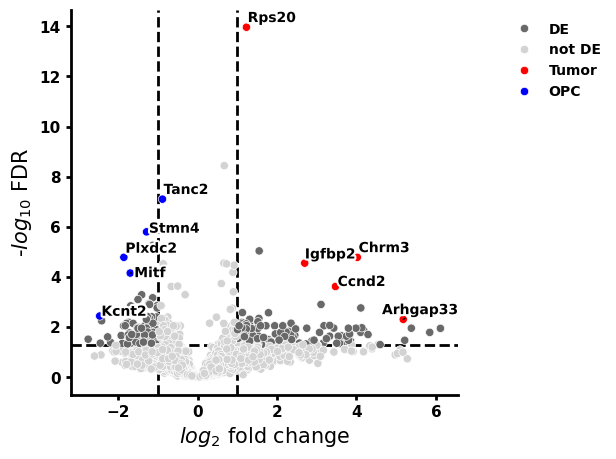

In [105]:
volcano(de, symbol="Symbol", log2fc_thresh = 1, to_label = 5, 
        color_dict = {
            "OPC" : ["Tanc2", "Stmn4", "Plxdc2", "Mitf", "Kcnt2"],
            "Tumor" : ["Rps20", "Igfbp2", "Chrm3", "Ccnd2", "Arhgap33"]
        },
        colors = ["dimgrey", "lightgrey", "red", "blue"], 
        save = os.path.join(plot_path, 'X_opc_tumor_volcano(whole)'))

In [108]:
hallmark = gmt_to_decoupler(mh_path)
hallmark

,geneset,genesymbol
0,HALLMARK_ADIPOGENESIS,Abca1
1,HALLMARK_ADIPOGENESIS,Abcb8
2,HALLMARK_ADIPOGENESIS,Acaa2
3,HALLMARK_ADIPOGENESIS,Acadl
4,HALLMARK_ADIPOGENESIS,Acadm
...,...,...
7184,HALLMARK_XENOBIOTIC_METABOLISM,Upb1
7185,HALLMARK_XENOBIOTIC_METABOLISM,Upp1
7186,HALLMARK_XENOBIOTIC_METABOLISM,Vnn1
7187,HALLMARK_XENOBIOTIC_METABOLISM,Vtn


In [109]:
geneset_size = hallmark.groupby('geneset').size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [110]:
t_stats = sigs[['stat']].copy()
t_stats.rename(columns = {'stat': 'scores'}, inplace = True)
t_stats

,scores
Xkr4,-3.465680
Snhg6,3.251746
Rpl7,3.424585
Gpr45,-4.741949
Stat1,3.329030
...,...
Msn,3.324882
Rps4x,3.860057
Nxt2,-3.053994
Zrsr2,3.892853


In [112]:
scores, norm, pvals = decoupler.run_gsea(t_stats.T, hallmark[hallmark.geneset.isin(gsea_genesets)], source = 'geneset', target='genesymbol')

In [113]:
gsea_results = pd.concat({"score" : scores.T, "norm" : norm.T, "pval" : pvals.T}, axis = 1).droplevel(1, axis = 1).sort_values('pval')
gsea_results['-log10(pval)'] = -np.log10(gsea_results.pval)
gsea_results

,score,norm,pval,-log10(pval)
source,,,,
HALLMARK_MYC_TARGETS_V1,0.498084,2.083597,0.037197,1.429494
HALLMARK_P53_PATHWAY,0.575660,1.920627,0.054779,1.261387
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.631970,1.722576,0.084965,1.070758
HALLMARK_G2M_CHECKPOINT,0.483019,1.666029,0.095708,1.019054
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.574627,1.634427,0.102169,0.990680
HALLMARK_APOPTOSIS,0.557085,1.602130,0.109127,0.962068
HALLMARK_E2F_TARGETS,0.479401,1.444553,0.148584,0.828029
HALLMARK_ALLOGRAFT_REJECTION,0.452102,1.431855,0.152185,0.817627
HALLMARK_IL2_STAT5_SIGNALING,0.459549,1.239904,0.215011,0.667540


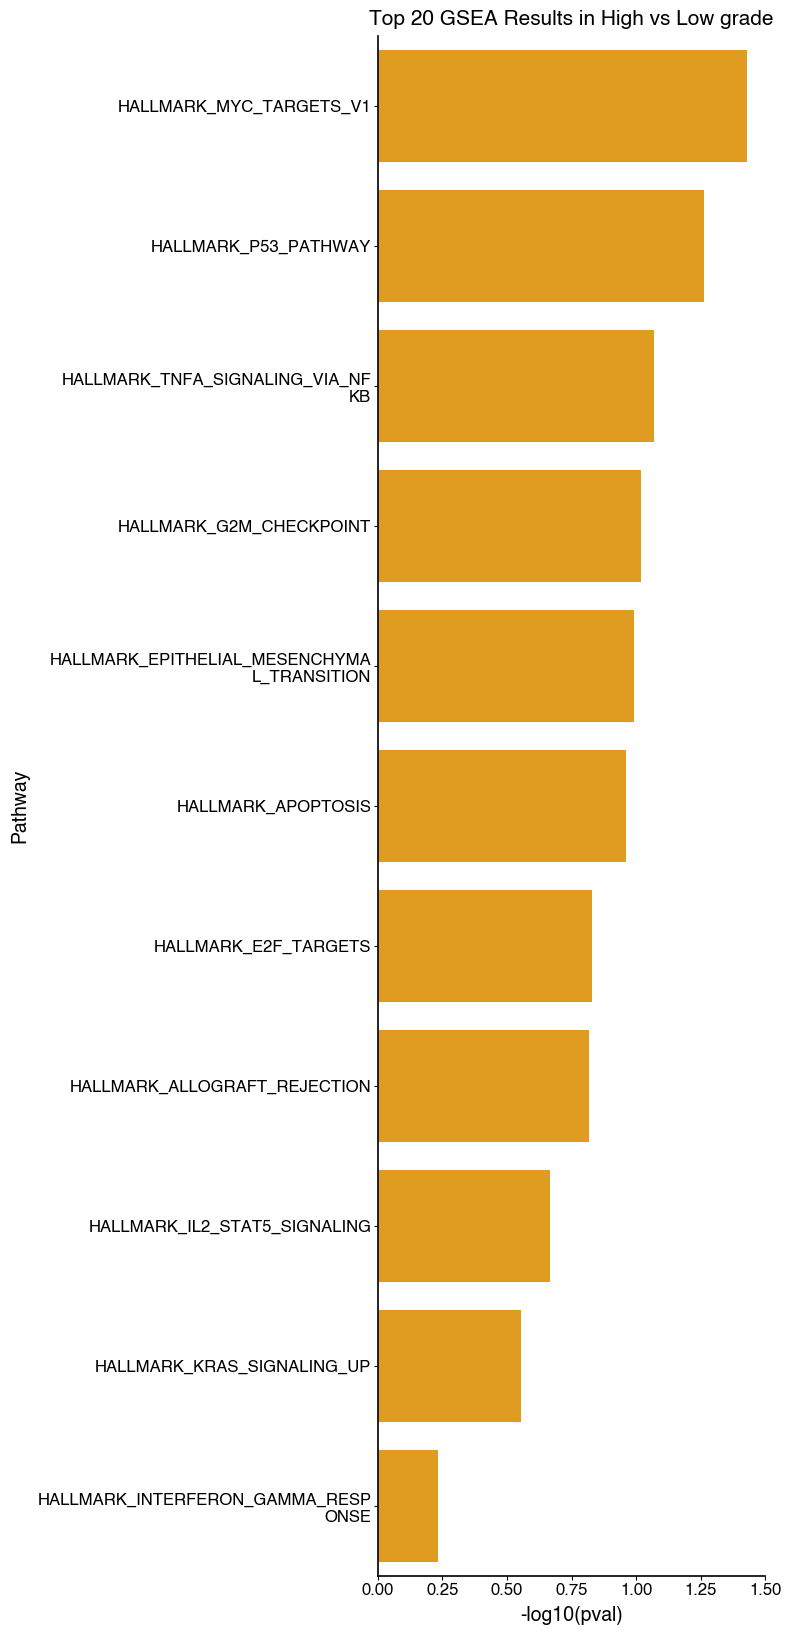

In [115]:
import textwrap

def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, rotation=0, ha='right')

with mplscience.style_context():
    plt.figure(figsize = (5, 20))
    ax = sns.barplot(gsea_results.head(20), x = '-log10(pval)', y = gsea_results.head(20).index, color = 'orange')
    wrap_labels(ax, 30)
    plt.xlabel('-log10(pval)')
    plt.ylabel('Pathway')
    plt.title('Top 20 GSEA Results in High vs Low grade')
    plt.savefig(os.path.join(plot_path, 'X_GSEA_OPCvsTumor.pdf'), dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()